# 5. Further improving the model with a custom loss function

 ## 5.1 Creating a model with a custom loss function
 With our current model the correlation between the distances in compressed space and Z500 is higher than the correlation between compressed space and MSP. We would prefer a more balanced correlation between the two and if possible also a higher correlation between compressed and uncompressed space in general. In order to reach that goal, we could try to build a model that gives "more attention" to MSP than to Z500. This could be accomplished by training the model using a loss function that give a higher weight to MSP compared to Z500. 
 
 Let's start with loading the needed modules and creating the train, validate and test datasets.

In [1]:
import numpy as np
import keras
from keras import layers
from keras.models import save_model, load_model
from keras.callbacks import TensorBoard
from isoplot import isoplot
# Set location of data file
file="data/era20c.npy"

In [2]:
# N is the size of the test and validation dataset
N = 2000
data = np.load(file)
i = np.argsort(np.random.random(data.shape[0]))
data = data[i]
test = data[:N//2]
validate = data[N//2:N]
train = data[N:]

Now we create a custom weighted MSE loss function. The loss function gives a loss for every node for every sample in a batch (back propagation is done after a batch of samples). A higher weight is given to the MSE for MSL, a lower to the MSE for Z500. Going through some learning cycles, we observe an improvement when increasing the weighting "factor", going to an optimum by a factor of 0.22 and then declining when increasing the factor further. 

In [3]:
import keras.backend as K
def weighted_mse(y_true, y_pred):
    factor = 0.22
    loss_msl = K.square(y_pred[:,:,:,0] - y_true[:,:,:,0]) * (1. + factor)
    loss_z500 = K.square(y_pred[:,:,:,1] - y_true[:,:,:,1]) * (1. - factor)
    loss = K.stack((loss_msl,loss_z500), axis=3)        # (batch_size,32,64,2)
    return loss

We use the same model, but now with our custom MSE loss function.

In [4]:
# Encoder (32,64,2) - > (4,8,1)
input = keras.Input(shape=(32, 64, 2))
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
encoded = layers.Conv2D(1, (3, 3), activation='relu', padding='same')(x)

# Decoder (4,8,1) -> (32,64,2)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu',padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(2, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input, decoded)
autoencoder.compile(optimizer='adam', loss=weighted_mse)
print(autoencoder.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 64, 2)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 64, 32)        608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 32, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 16, 16)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 16, 8)          1160  

2022-06-21 15:29:58.621199: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
autoencoder.fit(train, train,
                epochs=35,
                batch_size=256,
                shuffle=True,
                validation_data=(validate, validate),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

autoencoder.save("data/autoencoder_weighted.h5")

Epoch 1/35
151/151 [==============================] - 75s 492ms/step - loss: 0.0105 - val_loss: 0.0041
Epoch 2/35
151/151 [==============================] - 76s 505ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 3/35
151/151 [==============================] - 77s 509ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 4/35
151/151 [==============================] - 80s 533ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 5/35
151/151 [==============================] - 76s 504ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 6/35
151/151 [==============================] - 76s 505ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 7/35
151/151 [==============================] - 76s 500ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 8/35
151/151 [==============================] - 77s 509ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 9/35
151/151 [==============================] - 76s 504ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 10/35
151/151 [==============================] - 75s 494ms/step - l

Let's compare the MSE and Z500 isoplots after (de)compression with the original.

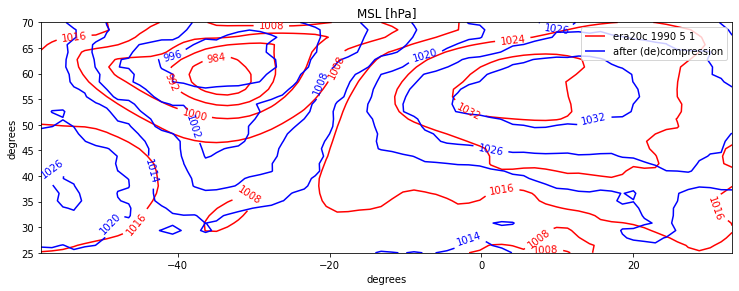

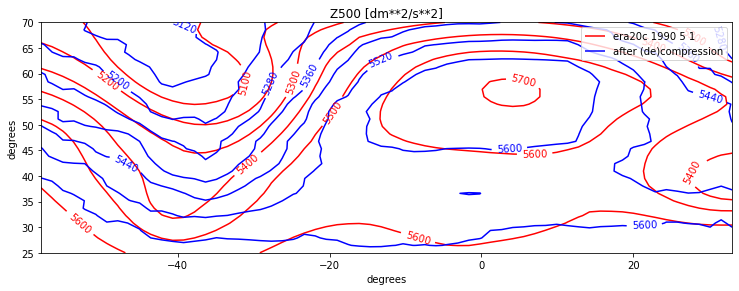

In [5]:
# set date "%Y %-m %-d"
date = "1990 5 1"

# load data
autoencoder = load_model("data/autoencoder_weighted.h5",compile=False)
x = np.load(file)
dates = np.load("data/dates.npy")
zone = np.load("data/zone.npy")
scale = np.load("data/scale.npy")
date_index = np.where(dates == date)
x_in = x[date_index]

# compare output with input
x_out = autoencoder.predict(x_in) 
isoplot(x_in[0,:,:,0],x_out[0,:,:,0],"era20c "+date,"after (de)compression",zone,scale[0])
isoplot(x_in[0,:,:,1],x_out[0,:,:,1],"era20c "+date,"after (de)compression",zone,scale[1]*10,"Z500 [dm**2/s**2]")

## 5.2 Compressing the dataset with the improved model
For compressing the dataset, we need to cut our the encoding part of the autoencoder.

In [6]:
from keras.models import load_model, Model
encode_end = 7

autoencoder = load_model("data/autoencoder_weighted.h5",compile=False)
compress = Model(inputs=autoencoder.input, outputs=autoencoder.layers[encode_end].output)
compress.summary()
compress.save("data/compress_weighted.h5")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 64, 2)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 64, 32)        608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 32, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 16, 16)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 16, 8)          1160

Now we can compress the dataset with the new model

In [7]:
x_compress = compress.predict(x)
np.save("data/era20c_compressed_weighted.npy", x_compress)

## 5.3 Search with the improved model
Let's start with loading the libraries and data.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from isoplot import isoplot

# load data
era20c = np.load("data/era20c.npy")
compressed = np.load("data/era20c_compressed_weighted.npy")
dates = np.load("data/dates.npy")
scale = np.load("data/scale.npy")
zone = np.load("data/zone.npy")

# reshaping 2 spatial dimensions to 1, to be able to use the numpy norm
shape1 = era20c.shape[1]
shape2 = era20c.shape[2]
grid_points = shape1 * shape2
grid_sqrt = np.sqrt(grid_points) 
era20c = era20c.reshape(era20c.shape[0],grid_points,era20c.shape[3])
compressed = compressed.reshape(compressed.shape[0],compressed.shape[1]*compressed.shape[2]*compressed.shape[3])

Here you can set a date and search with the custom loss model.

In [9]:
# set the reference date here
date = "1990 1 25"
#date = "1953 1 31"
#date = "1976 1 2"
#date = "1976 8 1"
#date = "2003 8 10"

# corresponding reference data
date_index = np.where(dates == date)
compressed_ref = compressed[date_index]
era20c_ref = era20c[date_index]

# initialize arrays
compressed_dist = np.zeros(dates.shape[0])
msl_dist = np.zeros(dates.shape[0])
z500_dist = np.zeros(dates.shape[0])
era20c_dist = np.zeros(dates.shape[0])

# calculate distances
for i in range(dates.shape[0]):
    compressed_dist[i] = np.linalg.norm(compressed[i]-compressed_ref)
    era20c_dist[i] = np.linalg.norm(era20c[i]-era20c_ref)
    msl_dist[i] = np.linalg.norm((era20c[i,:,0]-era20c_ref[0,:,0]))
    z500_dist[i] = np.linalg.norm((era20c[i,:,1]-era20c_ref[0,:,1]))
    
# unscale and divide by number of gridpoints
msl_dist = msl_dist * (scale[0,1]-scale[0,0]) / grid_sqrt
z500_dist = z500_dist * (scale[1,1]-scale[1,0]) / grid_sqrt

# smallest distances
smallest_compressed = np.argsort(compressed_dist)[:25]
print("Index\tDate\t\tCompr.Dist.\tUncompr.Dist.\tMSL Dist.[Pa]\tZ500 Dist.[m**2/s**2]")
for i in smallest_compressed:
    print("%d\t%s\t%.3f\t\t%.3f\t\t%.0f\t\t%.0f" % (i,dates[i],compressed_dist[i],era20c_dist[i],msl_dist[i],z500_dist[i]))

Index	Date		Compr.Dist.	Uncompr.Dist.	MSL Dist.[Pa]	Z500 Dist.[m**2/s**2]
32896	1990 1 25	0.000		0.000		0		0
23757	1965 1 17	0.322		3.086		715		604
36154	1998 12 27	0.331		3.307		732		699
31432	1986 1 22	0.351		3.826		778		895
32897	1990 1 26	0.360		3.571		851		661
31493	1986 3 24	0.375		3.340		691		768
32142	1988 1 2	0.386		3.450		802		672
32180	1988 2 9	0.389		3.664		852		713
32913	1990 2 11	0.394		3.791		796		857
30693	1984 1 14	0.394		3.731		771		859
33239	1991 1 3	0.415		3.445		738		760
24912	1968 3 17	0.418		4.196		944		865
17896	1948 12 31	0.432		4.299		857		1026
22252	1960 12 4	0.434		3.930		814		902
28093	1976 12 1	0.435		4.290		897		975
20801	1956 12 14	0.440		4.050		886		870
31431	1986 1 21	0.444		4.592		1072		888
3299	1909 1 13	0.450		4.198		942		868
8093	1922 2 28	0.453		4.416		864		1072
4325	1911 11 5	0.455		4.111		686		1110
39056	2006 12 7	0.457		4.181		806		1028
33241	1991 1 5	0.458		4.024		853		901
36174	1999 1 16	0.459		3.807		799		862
31497	1986 3 28	0.461		4.636		96

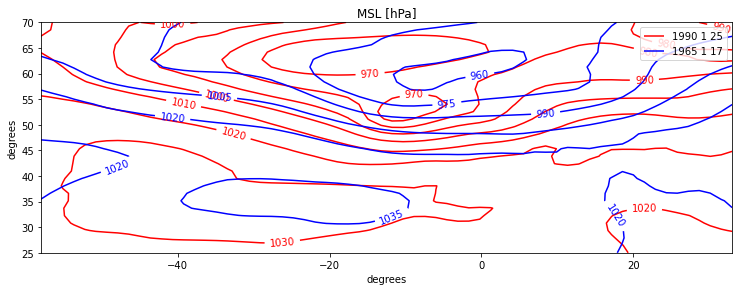

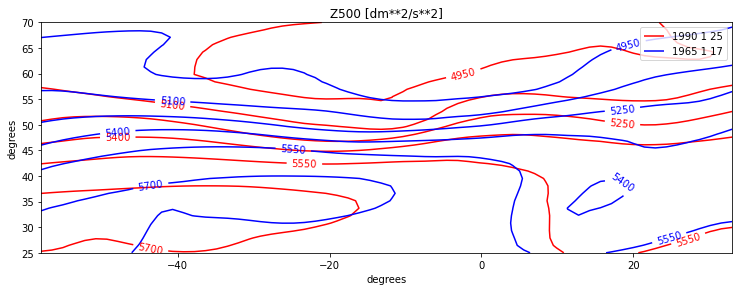

In [10]:
# for 2nd smallest: set nearby to 2
nearby = 1
min_dist_index = smallest_compressed[nearby]  
original = era20c[date_index].reshape(1,shape1,shape2,2)
nearest = era20c[min_dist_index].reshape(1,shape1,shape2,2)
isoplot(original[0,:,:,0],nearest[0,:,:,0],date,dates[min_dist_index],zone,scale[0])
isoplot(original[0,:,:,1],nearest[0,:,:,1],date,dates[min_dist_index],zone,scale[1]*10,"Z500 [dm**2/s**2]")

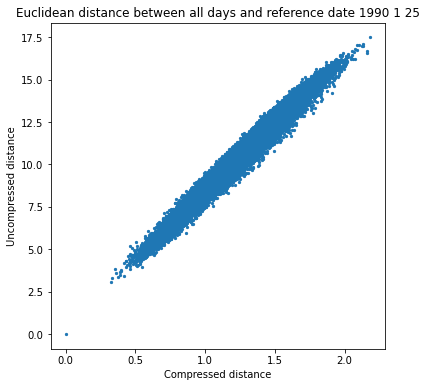

Pearson correlation coefficient: 0.987


In [11]:
plt.rcParams["figure.figsize"] = (6,6)
plt.scatter(compressed_dist, era20c_dist, s=5)
plt.ylabel("Uncompressed distance")
plt.xlabel("Compressed distance")
plt.title("Euclidean distance between all days and reference date " + date)
plt.show()
print("Pearson correlation coefficient: %.3f" % np.corrcoef(compressed_dist,era20c_dist)[0,1])

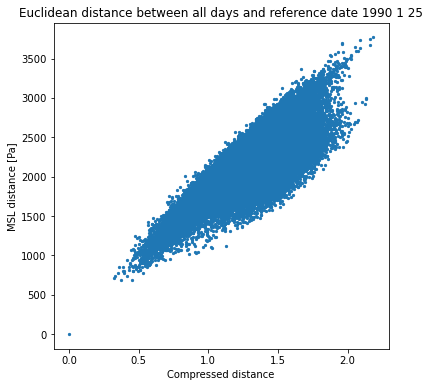

Pearson correlation coefficient: 0.785


In [12]:
plt.rcParams["figure.figsize"] = (6,6)
plt.scatter(compressed_dist, msl_dist, s=5)
plt.ylabel("MSL distance [Pa]")
plt.xlabel("Compressed distance")
plt.title("Euclidean distance between all days and reference date " + date)
plt.show()
print("Pearson correlation coefficient: %.3f" % np.corrcoef(compressed_dist,msl_dist)[0,1])

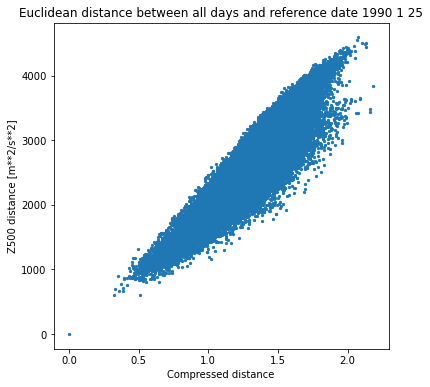

Pearson correlation coefficient: 0.912


In [13]:
plt.rcParams["figure.figsize"] = (6,6)
plt.scatter(compressed_dist, z500_dist, s=5)
plt.ylabel("Z500 distance [m**2/s**2]")
plt.xlabel("Compressed distance")
plt.title("Euclidean distance between all days and reference date " + date)
plt.show()
print("Pearson correlation coefficient: %.3f" % np.corrcoef(compressed_dist,z500_dist)[0,1])